<a href="https://colab.research.google.com/github/bradleywhitlock/CDP-Exploration/blob/master/Introduction_to_Data_Exploration_CDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Data Visualization @ Cognite

## What this notebook will achieve

* Extract live data from an oil rig in the North Sea.

* Visualize and inspect data directly from the Cognite Data Platform.

* How to run a machine learning model on the data.


## Getting started

* Having a basic understanding of Python concepts will help to understand the process.

* Cognite has released *live* data to the public on the Cognite Data Platform streaming from [Valhall](https://www.akerbp.com/en/our-assets/production/valhall/), one of Aker's oil fields.

* To access the data, generate an API Key on [Open Industrial Data](https://openindustrialdata.com/). Get your key via the Google Access platform. You will be asked to fill out some personal information to generate your personal key.

* Visualize some of the machines (assets) on Valhall with Cognite's [Operational Intelligence](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard. This data on this page shows is streaming live data from the Valhall oil field located in the North Sea.

* To understand how to interact with the data using the Python SDK ([Docs](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/)) follow along in this notebook.

## Environment Setup

#### Install the Cognite SDK package

In [8]:
!pip install cognite-sdk

#### Import the required packages

In [0]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from cognite import CogniteClient

#### Connect to the Cognite Data Platform
* This client object is how all queries will be sent to the Cognite API to retrieve data.

When prompted for your API key, use the key generated by open industrial data as mentioned in the Getting Started steps.

In [4]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "))

Open Industrial Data API-KEY: ··········


## Accessing Cognite Data Platform (CDP)
* The CDP organizes digital information about the physical world.
* There are 6 kinds of objects stored on the CDP. Each of these objects in the CDP are labelled with a unique ID. Information regarding a specific Asset, Event, etc are often retrieved using this ID.

  * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil platform.
  
  * [Event](https://doc.cognitedata.com/api/0.5/#tag/Events) objects store complex information about multiple assets over a time period. For example, an event can describe two hours of maintenance on a water pump and some associated pipes.
  
  * A [File](https://doc.cognitedata.com/api/0.5/#tag/Files) stores a sequence of bytes connected to one or more assets. For example, a file can contain a piping and instrumentation diagram (P&IDs) showing how multiple assets are connected.
  
  * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.
  
  * [Sequence](https://doc.cognitedata.com/api/0.5/#tag/Sequences) are similar to time series in that they are a key value pair, but rather than using a timestamp as the key, another measurment such as depth could be the key. For example, this is used in practice when drilling and taking measurments at various depths.
  
  * A [3D](https://doc.cognitedata.com/api/0.5/#tag/3D) model is typically built up by a hierarchical structure. This looks very similar to how we organize our internal asset hierarchy. 3D models are visualized via Cognite's dashboards.
  
* It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

### Collecting Asset Information

#### Retrieve a list of all Assets

* There are thousands of Assets in the CDP, we can have a look at a few examples.

* This will generate a list of assets from the CDP with no particular filters, this is a random result. Generally we would want to apply filters when retrieving records.


In [7]:
client.assets.get_assets().to_pandas().head()

,createdTime,depth,description,id,lastUpdatedTime,metadata,name,parentId,path
0,0,2,GAS COMPRESSION AND RE-INJECTION (PH),3111454725058294,0,"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",23,4650652196144007,"[6687602007296940, 4650652196144007, 311145472..."
1,0,7,1ST STAGE COMP DRY GAS SEAL SYS ON PH,3904753668320840,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-1ST STAGE COMP DRY GAS SEAL SYS-PH,4856008121737468,"[6687602007296940, 4650652196144007, 311145472..."
2,0,7,1ST STAGE COMP ENCLOSURE ON PH,2499711953216311,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-1ST STAGE COMP ENCLOSURE-PH,4856008121737468,"[6687602007296940, 4650652196144007, 311145472..."
3,0,7,1ST STAGE COMP LUBE OIL SYS ON PH,2137557577165478,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-1ST STAGE COMP LUBE OIL SYS-PH,4856008121737468,"[6687602007296940, 4650652196144007, 311145472..."
4,0,4,1ST STAGE COMPRESSION ON PH,4518112062673878,0,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",23-1ST STAGE COMPRESSION-PH,6895991969886325,"[6687602007296940, 4650652196144007, 311145472..."


#### Decide on which asset we want to explore
* To get started exploring data in the CDP, we must first decide on which Asset we want to gather information from.

* Some asset names may be retrieved from the [Op Int](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard.

* Here is a screehshot of the [OpInt Dashboard](https://drive.google.com/open?id=1f_7nJaJu5Xgr3Oq09mIZ0KwjBAYbzEUQ) incase the page does not load.

* Some example asset names are:
  * 23-HA-9103
  * 23-PV-92583
  * 23-VG-9101
  
The *fuzzy* search for an asset can be performed as followed


In [0]:
asset_name = "23-HA-9103"
asset_df = client.assets.search_for_assets(name=asset_name).to_pandas()
asset_df.head()


,createdTime,depth,description,id,lastUpdatedTime,metadata,name,parentId,path
0,0,6,VRD - 1ST STAGE SUCTION COOLER,2861239574637735,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",23-HA-9103,2513266419866445,"[6687602007296940, 4650652196144007, 311145472..."
1,0,6,VRD - 1ST STAGE DISCHARGE COOLER 2,1305599545806638,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",23-HA-9115,2513266419866445,"[6687602007296940, 4650652196144007, 311145472..."
2,0,8,VRD - 1ST STAGE COMPRESSOR LUBE OIL COOLER A,4965752723543746,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '786890', ...",23-HA-9107A,2137557577165478,"[6687602007296940, 4650652196144007, 311145472..."
3,0,6,VRD - 1ST STAGE DISCHARGE COOLER 1,5345363121325760,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",23-HA-9114,2513266419866445,"[6687602007296940, 4650652196144007, 311145472..."
4,0,8,VRD - 1ST STAGE COMPRESSOR LUBE OIL COOLER B,6838563873305104,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '786896', ...",23-HA-9107B,2137557577165478,"[6687602007296940, 4650652196144007, 311145472..."


#### Get information on the asset of interest

* We can filter the assets to get asset-specific details based on asset_name

* The *get_asset()* interface provides the same information for 1 specific asset based on the provided ID


In [0]:
asset_id = asset_df[asset_df["name"] == asset_name].iloc[0]['id']
asset = client.assets.get_asset(asset_id=asset_id).to_pandas()
asset

,0
id,2861239574637735
depth,6
name,23-HA-9103
parentId,2513266419866445
description,VRD - 1ST STAGE SUCTION COOLER
metadata,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ..."
createdTime,0
lastUpdatedTime,0
path,"[6687602007296940, 4650652196144007, 311145472..."


#### How do we get Asset relationships?

* The interface *get_asset_subtree()* can be used to retrieve the *children* of an Asset. 

* Each Asset is given various properties, some of the useful ones for this method are:

  * Depth: The number of edges from the parent node
  
  * Description: Includes information such as the platform and type of sensor being monitored
  
We will generate a list of all children of the main asset of interest. This is done by specifying a depth of 1.

In [0]:
subtree_df = client.assets.get_asset_subtree(asset_id=asset_id, depth=1).to_pandas()
subtree_df.head()

,createdTime,depth,description,id,lastUpdatedTime,metadata,name,parentId,path
0,0,6,VRD - 1ST STAGE SUCTION COOLER,2861239574637735,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",23-HA-9103,2513266419866445,"[6687602007296940, 4650652196144007, 311145472..."
1,0,7,VRD - PH 1STSTGSUCTCOOL SHELL PSV IN,274450897701725,0,"{'ELC_STATUS_ID': '1225', 'RES_ID': '444134', ...",45-HV-92510-01,2861239574637735,"[6687602007296940, 4650652196144007, 311145472..."
2,0,7,VRD - PH 1STSTGSUCTCLR GAS IN,576308321452985,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '609895', ...",23-ESDV-92501A,2861239574637735,"[6687602007296940, 4650652196144007, 311145472..."
3,0,7,VRD - PH 1STSTGSUCTCOOL SHELL PSV OUT,619750565594754,0,"{'ELC_STATUS_ID': '1225', 'RES_ID': '510103', ...",45-HV-92510-03,2861239574637735,"[6687602007296940, 4650652196144007, 311145472..."
4,0,7,VRD - PH 1STSTGSUCTCOOL COOLMED OUT,705952550422793,0,"{'ELC_STATUS_ID': '1211', 'RES_ID': '485917', ...",45-PT-92508,2861239574637735,"[6687602007296940, 4650652196144007, 311145472..."


### Collecting Time Series Information and Data Points

* Time Series objects contain the bulk of information in the CDP.

* Time Series objects are generally linked to an asset through the asset_id field.

* The *get_time_series()* method has a variety of filters, all are listed in the SDK.

* By specifying **asset_id** we will get a dataframe of all the associated time series objects with that asset, this is seen below.

#### Compile a list of time series objects under the asset
* For each of the children assets, get the associated time series objects and merge them into a DataFrame

In [0]:
all_ts_df = pd.DataFrame()

for index, asset in subtree_df.iterrows():
  ts_df = client.time_series.get_time_series(asset_id=int(asset['id'])).to_pandas()
  
  if not ts_df.empty:
    all_ts_df = all_ts_df.append(ts_df, ignore_index=True)
    
all_ts_df

,assetId,createdTime,description,id,isStep,isString,lastUpdatedTime,name
0,705952550422793,0,PH 1stStgSuctCool CoolMed Out,3529821833330815,False,False,0,VAL_45-PT-92508:X.Value
1,786220428505816,0,PH 1stStgSuctCool Gas In,3518012501014915,False,False,0,VAL_23-FT-92512:X.Value
2,2814662602621825,0,PH 1stStgSuctCool Gas In,6156871056679530,False,False,0,VAL_23-PT-92512:X.Value
3,4840206559741735,0,PH 1stStgSuctCool Gas In,5474031062875475,False,False,0,VAL_23-TT-92502:X.Value
4,5193727763959013,0,PH 1stStgSuctCool Gas Out,7491681405625794,False,False,0,VAL_23-PT-92504:X.Value
5,5439867226448359,0,PH 1stStgSuctCool Gas In,988967451935968,False,False,0,VAL_23-TT-92512:X.Value
6,5497674254221099,0,PH 1stStgSuctCool CoolMed In,1920137775628302,False,False,0,VAL_45-FT-92506:X.Value
7,5552927149248373,0,PH 1stStgSuctCool Gas In ESDV,5880632484472759,False,False,0,VAL_23-PDT-92501:X.Value
8,5891006566061532,0,PH 1stStgSuctClr CoolMed Out,3929156348065703,False,False,0,VAL_45-TT-92508:X.Value
9,6681756879590530,0,PH 1stStgSuctCool Tubes,7891376783606949,False,False,0,VAL_23-PDT-92502:X.Value


#### View datapoints for one of the time series

* Now that we have a list of all of the time series directly related to the immediete childern of our asset, we can retrieve datapoints for some of the them.

* A Datapoint in the CDP is stored as a key value pair

  * timestamp is the time since epoch in milliseconds
  
  * value is the reading from the sensor
  
The identifier to retrieve Datapoints is the **name** column from the DataFrame above.

In [0]:
client.datapoints.get_datapoints("VAL_45-PT-92508:X.Value", start="10d-ago").to_pandas().head()

,timestamp,value
0,1548700082363,2.184436
1,1548700083363,2.188586
2,1548700084363,2.189624
3,1548700085363,2.187549
4,1548700086363,2.188586


## Practical use case of the data in the CDP

* When gathering data from oil platforms, specific sensors can be very expensive to install and maintain.

* A technique often used it to use a combination of other sensor readings to predict another.

* The rest of the notebook will be used to retrieve data and create the model.

#### Collect datapoints from CDP

* The following 4 columns were chosen in an effort to estimate the output pressure of the suction cooler

* Input variables:

  * FT: Input Flow Rate
  
  * PT: Input Pressure
  
  * TT: Input Temperature
  
* Output variables:

  * Output *Pressure* 
  
The time series names are defined in the *in_ts_names* and *out_ts_names* lists below.


#### Aside: Cool exercise when the introduction is completed!!!

* Add/Delete input time series or change the output and see how the predictions and results change!

  * This can be done 

  

In [0]:
in_ts_names = ["VAL_23-FT-92512:X.Value", "VAL_23-PT-92512:X.Value", "VAL_23-TT-92502:X.Value"]
out_ts_name = "VAL_23-PT-92504:X.Value"


['VAL_23-FT-92512:X.Value', 'VAL_23-PT-92512:X.Value', 'VAL_23-TT-92502:X.Value', 'VAL_23-PT-92504:X.Value']


#### Retrieve Data Points from CDP

* Datapoints are returned in a pandas dataframe using the method *get_datapoints_frame()*, [documentation](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html#cognite.client.stable.datapoints.DatapointsClient.get_datapoints_frame).

* The advantage of using this method over *get_datapoints()* is that the data is aggregated to a common timestamp. The processing is taken care of in the API.

  * The common timestep is assigned using *granularity* argument. In this case, 1 minute was chosen.
 
Also performed is a step to rename the columns to their original, as the get_datapoints_frame method adds suffixes based on the aggregate.

In [0]:
ts_names = in_ts_names + [out_ts_name]

train_start_date = datetime(2018, 8, 1)
# 30 days of training data chosen arbitrarily
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.get_datapoints_frame(time_series=ts_names,
                                                       aggregates=['avg'],
                                                       granularity='1m',
                                                       start=train_start_date,
                                                       end=train_end_date
                                                       )
# Remove the "|average" appended to the end of the column names
datapoints_df.columns = ["timestamp"] + ts_names
datapoints_df.head()

,timestamp,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
0,1533081600000,91120.918480,3.374376,44.184863,3.251437
1,1533081660000,86259.975220,3.395966,44.232420,3.274299
2,1533081720000,90750.665657,3.410101,44.161438,3.287578
3,1533081780000,91948.525170,3.358822,43.986025,3.237081
4,1533081840000,93779.111997,3.429458,43.797913,3.306391


#### Visualize the Time Series data
* Utilize matplotlib to visualize each of the time series plots

The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

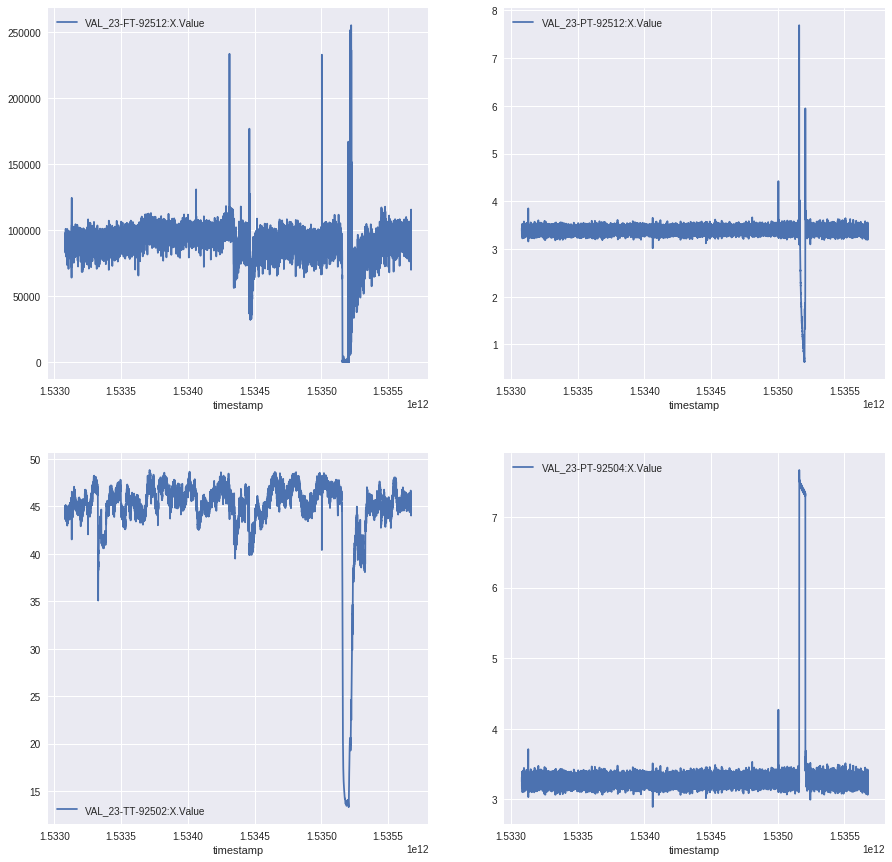

In [0]:
cols = list(datapoints_df.columns)
cols.remove('timestamp')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for i, col in enumerate(cols):
  datapoints_df.plot(x='timestamp', y=col, ax=axes[int(i>1), i%2]);

# Construct a model


### Gather the training data using the data from the figures above

In [0]:
train_X = datapoints_df[in_ts_names].values
train_y = datapoints_df[out_ts_name].values

### Get a seperate DataFrame from CDP for predictions

* The data which we will use to predict the output pressure will be stored in a seperate dataframe as collected below.

In [0]:
predict_start_date = train_end_date
# Make the prediction on 1 hour of data
predict_end_date = train_end_date + timedelta(hours=1)

predict_df = client.datapoints.get_datapoints_frame(time_series=ts_names,
                                                       aggregates=['avg'],
                                                       granularity='1m',
                                                       start=predict_start_date,
                                                       end=predict_end_date
                                                       )
predict_df.columns = ["timestamp"] + ts_names
predict_df = predict_df.fillna(method='ffill')
predict_df.head()

,timestamp,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
0,1535673600000,96596.397652,3.390761,44.822433,3.266866
1,1535673660000,92941.748459,3.382212,44.879119,3.259393
2,1535673720000,100634.003031,3.477319,45.053927,3.348573
3,1535673780000,103948.895082,3.434556,45.404786,3.305596
4,1535673840000,101079.342794,3.348590,45.698323,3.222974


## Linear Regression Model

* As a simple starting point we will check to see how a linear regression model performs to predict the output pressure

### Utilize *sklearn*  to create a basic linear regression model

* Sklearn is common package utilized to import and deploy data science models. Linear Regression is only 1 of many options for constructing models.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


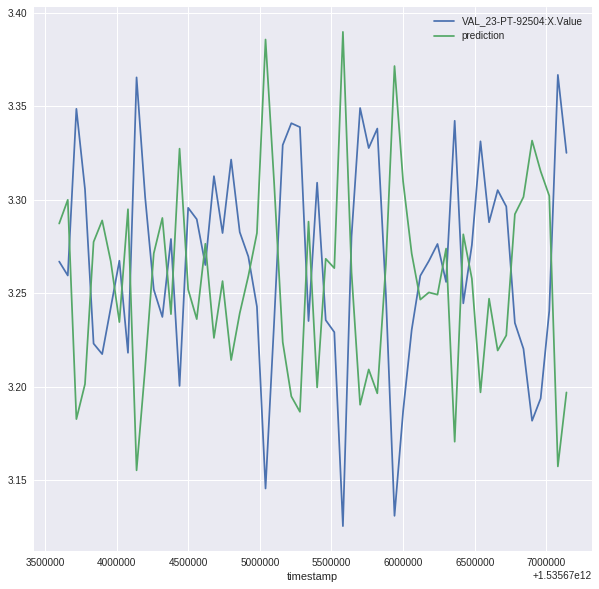

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

X = predict_df[in_ts_names].values
predict_df["prediction"] = lin_reg.predict(X)

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction"], figsize=(10,10));

### Results

* As seen in the above image, the Linear Regression model did not do a great job in predicting the pressure output.

* It is normal for the first model in a data science project to not perform as expected, there is a lot we can do to improve the results!

## Possible next steps???

1. Use a different model in an attempt to get better results in the pressure prediction.

2. Using a different asset from the [Op Int ](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard, gather time series similar to it was done here, and create plots to visualize the data.

3. Find the asset which has the greatest/least variance in sensor readings.

4. Any other cool findings, creativity is encouraged!